# Model Testing

In [1]:
import tensorflow as tf2
assert tf2.__version__ >= "2.0"
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Manager
import random
import os
from scipy.integrate import quad_vec  # quad_vec allows to compute integrals accurately
from scipy.stats import norm
from scipy.stats import qmc # to perform Latin Hypercube Sampling (LHS) 
import pandas as pd 

def set_random_seed(seed=42):
    tf.compat.v1.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING logs
tf = tf2.compat.v1
tf.logging.set_verbosity(tf.logging.ERROR)
set_random_seed()
real_type = tf.float32

## Load the dataset
feller_data = pd.read_csv('data//feller_d2.csv')

## Obtain 2nd order differentials and their PCs
second_differentials = feller_data.iloc[:,-36:]
normalized_zscore = (second_differentials - second_differentials.mean()) / second_differentials.std()
pca_d2 = PCA(n_components=15)
second_differential_label = pca_d2.fit_transform(normalized_zscore[:9000])

## Train-test Split (90-10)
feller_testing = feller_data.iloc[9000:]
feller_data = feller_data.iloc[:9000]

training_col = feller_data.columns[:8]
training_target = feller_data.columns[9]
network_inputs = feller_data[training_col].values
network_outputs = feller_data[training_target].values

func_names = ["lm", "r", "tau", "theta", "sigma", "rho", "kappa", "v0"]
network_inputs = feller_data[func_names]
option_prices = feller_data['P_hat']
network_first_order = feller_data[[f"diff wrt {col}" for col in func_names]].values
sec_order_names = []
for i in func_names:
    for j in func_names:
        if os.path.exists(f"data//d2_{i}_{j}.csv"):
            sec_order_names.append(f"d2_{i}_{j}")
network_second_order = feller_data[[f"{col}" for col in sec_order_names]].values


## Load the training records
combined_df = pd.read_csv("results//learning_history.csv")

In [2]:
def compute_grad_model1(model, raw_inputs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(raw_inputs) 
        option_price = model(raw_inputs)  
    first_order_differential = tape.gradient(option_price, raw_inputs)
    return option_price, first_order_differential

def compute_grad_model2(model, raw_inputs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(raw_inputs) 
        option_price = model(raw_inputs)
    first_order_differential = tape.gradient(option_price, raw_inputs)
    return option_price, first_order_differential
def compute_grad_model3(model, raw_inputs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(raw_inputs) 
        option_price, second_order_diff = model(raw_inputs)
    first_order_differential = tape.gradient(option_price, raw_inputs)
    return option_price, first_order_differential, second_order_diff

def compute_grad_model4(model, raw_inputs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(raw_inputs) 
        option_price, second_order_diff = model(raw_inputs)  
    first_order_differential = tape.gradient(option_price, raw_inputs)
    return option_price, first_order_differential, second_order_diff

Performance of Model 1

In [3]:
subset_0_1 = combined_df[(combined_df['source'] == 'history1')]
starting_point = 0
total_loss = subset_0_1["total_loss"].values[starting_point:][-1]
price_loss = subset_0_1["price_loss"].values[starting_point:][-1]
first_order_loss = subset_0_1["first_order_loss"].values[starting_point:][-1]

print(f"Total Loss: ${total_loss:.3f}")
print(f"Price Loss: ${price_loss:.3f}")
print(f"1st Order Differential Loss: ${first_order_loss:.3f}")


Total Loss: $0.181
Price Loss: $0.069
1st Order Differential Loss: $0.224


Performance of Model 2


In [4]:
subset_0_1 = combined_df[(combined_df['source'] == 'history2')].groupby(['lambda1'])
starting_point = 0
lambda_keys = [0.1, 0.5, 0.7]

for i in lambda_keys:
    total_loss = subset_0_1.get_group(i)["total_loss"].values[starting_point:][-1]
    price_loss = subset_0_1.get_group(i)["price_loss"].values[starting_point:][-1]
    first_order_loss = subset_0_1.get_group(i)["first_order_loss"].values[starting_point:][-1]
    print(f"Total Loss: ${total_loss:.3f}")
    print(f"Price Loss: ${price_loss:.3f}")
    print(f"1st Order Differential Loss: ${first_order_loss:.3f}")


Total Loss: $0.078
Price Loss: $0.070
1st Order Differential Loss: $0.075
Total Loss: $0.090
Price Loss: $0.075
1st Order Differential Loss: $0.030
Total Loss: $0.088
Price Loss: $0.076
1st Order Differential Loss: $0.017


Performance of Model 3

In [20]:
subset_0_1 = combined_df[(combined_df['source'] == 'history4')].groupby(['lambda1', 'lambda2'])
starting_point = 0
lambda_keys = [0.1, 0.5, 0.7]

table_data = []
for i in lambda_keys:
    for j in lambda_keys:
        total_loss = subset_0_1.get_group((i, j))["total_loss"].values[starting_point:][-1]
        price_loss = subset_0_1.get_group((i, j))["price_loss"].values[starting_point:][-1]
        first_order_loss = subset_0_1.get_group((i, j))["first_order_loss"].values[starting_point:][-1]
        second_order_loss = subset_0_1.get_group((i, j))["second_order_loss"].values[starting_point:][-1]
        table_data.append([i,j,total_loss,price_loss,first_order_loss,second_order_loss])

df = pd.DataFrame(table_data, columns=['Lambda1','Lambda2', 'Total Loss', 'Price Loss', '1st Order Loss', '2nd Order Loss'])
print(df)

   Lambda1  Lambda2  Total Loss  Price Loss  1st Order Loss  2nd Order Loss
0      0.1      0.1    0.224117    0.070678        0.069237        1.465150
1      0.1      0.5    0.302010    0.071235        0.041287        0.453294
2      0.1      0.7    0.289425    0.079906        0.039647        0.293649
3      0.5      0.1    0.107951    0.074218        0.013145        0.271608
4      0.5      0.5    0.169962    0.073988        0.012880        0.179066
5      0.5      0.7    0.174212    0.073952        0.012480        0.134314
6      0.7      0.1    0.094249    0.075086        0.008926        0.129141
7      0.7      0.5    0.129983    0.075026        0.009103        0.097169
8      0.7      0.7    0.137508    0.075077        0.009026        0.080161


Performance of Model 4

In [14]:
subset_0_1 = combined_df[(combined_df['source'] == 'history3')].groupby(['lambda1', 'lambda2'])
starting_point = 0
lambda_keys = [0.1, 0.5, 0.7]

table_data = []
for i in lambda_keys:
    for j in lambda_keys:
        total_loss = subset_0_1.get_group((i, j))["total_loss"].values[starting_point:][-1]
        price_loss = subset_0_1.get_group((i, j))["price_loss"].values[starting_point:][-1]
        first_order_loss = subset_0_1.get_group((i, j))["first_order_loss"].values[starting_point:][-1]
        second_order_loss = subset_0_1.get_group((i, j))["second_order_loss"].values[starting_point:][-1]
        table_data.append([i,j, total_loss, price_loss, first_order_loss,second_order_loss])

df = pd.DataFrame(table_data, columns=['Lambda1','Lambda2', 'Total Loss', 'Price Loss', '1st Order Loss', '2nd Order Loss'])
print(df)


   Lambda1  Lambda2  Total Loss  Price Loss  1st Order Loss  2nd Order Loss
0      0.1      0.1    0.156377    0.069493        0.095656        0.773187
1      0.1      0.5    0.193802    0.070729        0.046152        0.236914
2      0.1      0.7    0.187967    0.072102        0.033746        0.160700
3      0.5      0.1    0.095559    0.073957        0.014795        0.142048
4      0.5      0.5    0.120946    0.073790        0.013242        0.081070
5      0.5      0.7    0.121179    0.073750        0.012878        0.058556
6      0.7      0.1    0.087427    0.074938        0.009788        0.056373
7      0.7      0.5    0.102068    0.074925        0.009545        0.040922
8      0.7      0.7    0.102783    0.075139        0.009033        0.030459


Training Record

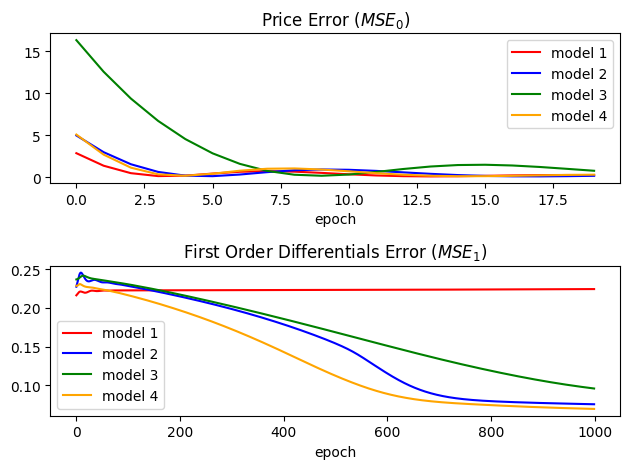

In [34]:
model_1 = combined_df[(combined_df['source'] == 'history1')]
model_2 = combined_df[(combined_df['source'] == 'history2')].groupby(['lambda1']).get_group(0.1)
model_3 = combined_df[(combined_df['source'] == 'history3')].groupby(['lambda1', 'lambda2']).get_group((0.1,0.1))
model_4 = combined_df[(combined_df['source'] == 'history4')].groupby(['lambda1', 'lambda2']).get_group((0.1,0.1))

fig, ax = plt.subplots(2,1)

model_color = ['r','b','g','orange']
for k, model in enumerate([model_1,model_2,model_3,model_4]):
    truncated_end = 20
    ax[0].plot(range(truncated_end),model['price_loss'][:truncated_end],color=model_color[k])
    ax[1].plot(range(1000),model['first_order_loss'][:1000],color=model_color[k])

ax[0].legend(["model 1","model 2","model 3","model 4"])
ax[1].legend(["model 1","model 2","model 3","model 4"])
ax[0].set_title(f"Price Error ($MSE_0$)")
ax[1].set_title(f"First Order Differentials Error ($MSE_1$)")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
plt.tight_layout()
plt.savefig("results//training_error.png")
plt.show()

Testing Performance

In [22]:
feller_data = pd.read_csv('data//feller_d2.csv')
feller_testing = feller_data.iloc[9000:]
func_names = ["lm", "r", "tau", "theta", "sigma", "rho", "kappa", "v0"]
testing_network_inputs = feller_testing[func_names]
testing_option_prices = feller_testing['P_hat']
testing_first_order = feller_testing[[f"diff wrt {col}" for col in func_names]].values

In [32]:
model1 = load_model("models//model1.h5")
predicted_price, predicted_first_order = compute_grad_model1(model1, tf.convert_to_tensor(testing_network_inputs))
mse1 = np.average((predicted_first_order-testing_first_order)**2)
mse0 = np.average((predicted_price-testing_option_prices)**2)
print(f"Model 1: {mse0:3f},{mse1:3f}")
model2 = load_model("models//model2_1.h5")
predicted_price, predicted_first_order = compute_grad_model2(model2, tf.convert_to_tensor(testing_network_inputs))
mse1 = np.average((predicted_first_order-testing_first_order)**2)
mse0 = np.average((predicted_price-testing_option_prices)**2)
print(f"Model 2: {mse0:3f},{mse1:3f}")
model3 = load_model("models//model3_1_1.h5")
predicted_price, predicted_first_order, _ = compute_grad_model3(model3, tf.convert_to_tensor(testing_network_inputs))
mse1 = np.average((predicted_first_order-testing_first_order)**2)
mse0 = np.average((predicted_price-testing_option_prices)**2)
print(f"Model 3: {mse0:3f},{mse1:3f}")
model4 = load_model("models//model4_1_1.h5")
predicted_price, predicted_first_order, _ = compute_grad_model4(model4, tf.convert_to_tensor(testing_network_inputs))
mse1 = np.average((predicted_first_order-testing_first_order)**2)
mse0 = np.average((predicted_price-testing_option_prices)**2)
print(f"Model 4: {mse0:3f},{mse1:3f}")

Model 1: 0.069223,0.229037
Model 2: 0.070697,0.077745
Model 3: 0.070180,0.098862
Model 4: 0.071455,0.071147


In [38]:
def collect_2nd_model(model_num):
    table_mse0 = []
    table_mse1 = []
    lambda_pairs = []
    for i in lambda_keys:
        for j in lambda_keys:
            model = load_model(f"models//model{model_num}_{int(i*10)}_{int(j*10)}.h5")
            predicted_price, predicted_first_order, _ = compute_grad_model3(model, tf.convert_to_tensor(testing_network_inputs))
            mse1 = np.average((predicted_first_order-testing_first_order)**2)
            mse0 = np.average((predicted_price-testing_option_prices)**2)
            lambda_pairs.append((i,j))
            table_mse0.append(mse0)
            table_mse1.append(mse1)
    return lambda_pairs, np.array(table_mse0), np.array(table_mse1)

lambda_paris, mse0_model3, mse1_model3 = collect_2nd_model(3)
_, mse0_model4, mse1_model4 = collect_2nd_model(4)

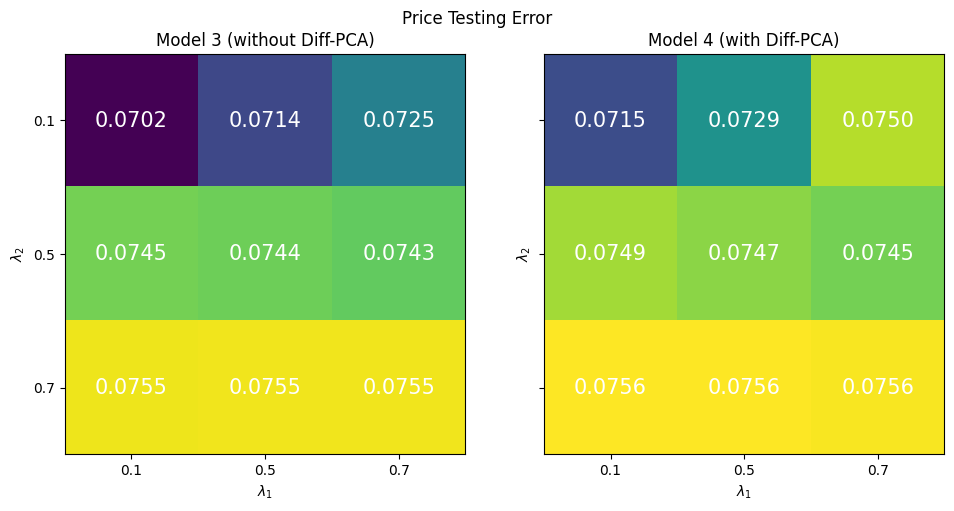

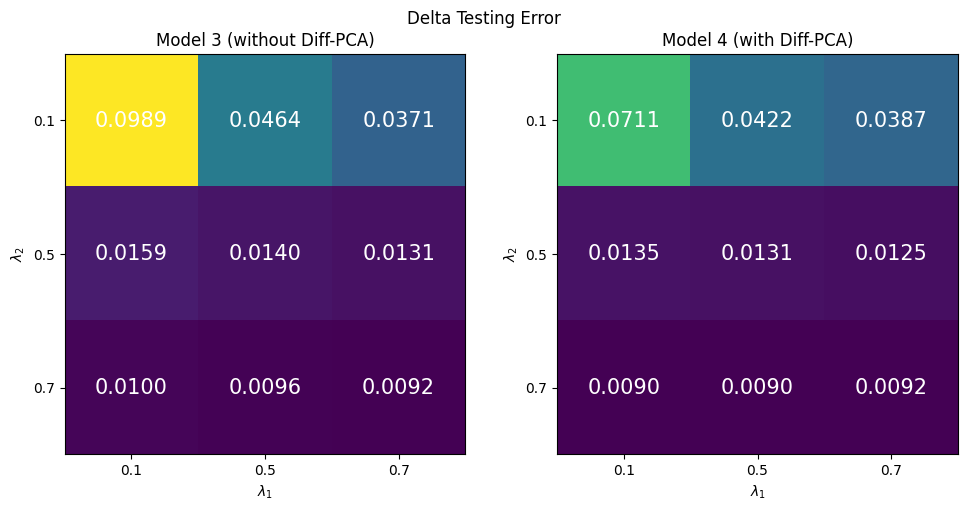

In [95]:
fig, ax = plt.subplots(1,2, figsize=(10,5),sharex=True,sharey=True)
vmax = np.max([mse0_model3,mse0_model4])
vmin = np.min([mse0_model3,mse0_model4])
img1 = ax[0].imshow(mse0_model3.reshape(3,3), vmax=vmax, vmin=vmin)
img2 = ax[1].imshow(mse0_model4.reshape(3,3), vmax=vmax, vmin=vmin)
data1 = mse0_model3.reshape(3,3)
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        ax[0].text(j, i, f"{data1[i, j]:.4f}", ha='center', va='center', color='white', size=15)
data1 = mse0_model4.reshape(3,3)
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        ax[1].text(j, i, f"{data1[i, j]:.4f}", ha='center', va='center', color='white', size=15)

ax[0].set_title("Model 3 (without Diff-PCA)")
ax[1].set_title("Model 4 (with Diff-PCA)")
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['0.1','0.5','0.7'])
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['0.1','0.5','0.7'])
ax[0].set_yticks([0,1,2])
ax[0].set_yticklabels(['0.1','0.5','0.7'])
ax[1].set_yticks([0,1,2])
ax[1].set_yticklabels(['0.1','0.5','0.7'])
ax[0].set_xlabel(f'$\lambda_1$')
ax[1].set_xlabel(f'$\lambda_1$')
ax[0].set_ylabel(f'$\lambda_2$')
ax[1].set_ylabel(f'$\lambda_2$')
fig.suptitle("Price Testing Error")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
vmax = np.max([mse1_model3,mse1_model4])
vmin = np.min([mse1_model3,mse1_model4])
img1 = ax[0].imshow(mse1_model3.reshape(3,3), vmax=vmax, vmin=vmin)
img2 = ax[1].imshow(mse1_model4.reshape(3,3), vmax=vmax, vmin=vmin)
data1 = mse1_model3.reshape(3,3)
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        ax[0].text(j, i, f"{data1[i, j]:.4f}", ha='center', va='center', color='white', size=15)
data1 = mse1_model4.reshape(3,3)
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        ax[1].text(j, i, f"{data1[i, j]:.4f}", ha='center', va='center', color='white', size=15)

ax[0].set_title("Model 3 (without Diff-PCA)")
ax[1].set_title("Model 4 (with Diff-PCA)")
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['0.1','0.5','0.7'])
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['0.1','0.5','0.7'])
ax[0].set_yticks([0,1,2])
ax[0].set_yticklabels(['0.1','0.5','0.7'])
ax[1].set_yticks([0,1,2])
ax[1].set_yticklabels(['0.1','0.5','0.7'])
ax[0].set_xlabel(f'$\lambda_1$')
ax[1].set_xlabel(f'$\lambda_1$')
ax[0].set_ylabel(f'$\lambda_2$')
ax[1].set_ylabel(f'$\lambda_2$')
fig.suptitle("Delta Testing Error")
plt.tight_layout()
plt.show()